In [10]:
import logging
import os

import pandas as pd

import isocomp
from isocomp.Compare import IsoformLibrary
from isocomp.Compare import utils as compare_utils

logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(name)s - '
                    '%(levelname)s - %(message)s')

logger = logging.getLogger('isocomp')

logger.debug(isocomp.__version__)
logger.debug(os.getcwd())

2022-12-26 06:58:31,949 - isocomp - DEBUG - 0.1.0
2022-12-26 06:58:31,951 - isocomp - DEBUG - /home/oguzkhan/code/isocomp/docs


In [3]:
d = dict(zip(['hg002_sqanti_fltr',
              'hg004_sqanti_fltr',
              'hg005_sqanti_fltr'],
             ['../src/tests/data/hg002_sqanti_fltr.fasta',
              '../src/tests/data/hg004_sqanti_fltr.fasta',
              '../src/tests/data/hg005_sqanti_fltr.fasta']))

clustered_gtf_path = '../src/tests/data/clustered_regions.gtf'

ia = IsoformLibrary(clustered_gtf_path,d)

2022-12-26 06:57:13,891 - root - DEBUG - trying to set new clustered_gtf_path: {new_path}
2022-12-26 06:57:13,932 - root - DEBUG - new dict: {'hg002_sqanti_fltr': '../src/tests/data/hg002_sqanti_fltr.fasta', 'hg004_sqanti_fltr': '../src/tests/data/hg004_sqanti_fltr.fasta', 'hg005_sqanti_fltr': '../src/tests/data/hg005_sqanti_fltr.fasta'}


In [4]:
ia.get_isoform('hg002_sqanti_fltr','PB.17.2',start=0,end=10)

'GAGAGGCAGC'

In [5]:
c1 = ia.get_cluster('1')

In [7]:
c1.unique_id

0    tx_0
1    tx_1
2    tx_2
3    tx_3
4    tx_4
Name: unique_id, dtype: object

In [12]:
pd.DataFrame.from_dict(compare_utils.vector_crosser(c1.unique_id,c1.unique_id))\
	.sort_values(by=['V1','V2'])

,V1,V2
2,tx_0,tx_1
1,tx_0,tx_2
3,tx_0,tx_3
0,tx_0,tx_4
7,tx_2,tx_1
8,tx_2,tx_3
9,tx_3,tx_1
5,tx_4,tx_1
4,tx_4,tx_2
6,tx_4,tx_3


In [13]:
c1

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,transcript_id,gene_id,Cluster,unique_id
0,chr1,hg004_sqanti_fltr,transcript,1013496,1014531,.,+,.,PB.13.1,PB.13,1,tx_0
1,chr1,hg005_sqanti_fltr,transcript,1013496,1014531,.,+,.,PB.17.1,PB.17,1,tx_1
2,chr1,hg005_sqanti_fltr,transcript,1013496,1014531,.,+,.,PB.17.2,PB.17,1,tx_2
3,chr1,hg002_sqanti_fltr,transcript,1013503,1014531,.,+,.,PB.17.2,PB.17,1,tx_3
4,chr1,hg004_sqanti_fltr,transcript,1013531,1014531,.,+,.,PB.13.2,PB.13,1,tx_4


In [24]:
ia.clustered_gtf[(ia.clustered_gtf.Source == 'hg002_sqanti_fltr') & (ia.clustered_gtf.transcript_id == 'PB.17.2')]

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,transcript_id,gene_id,Cluster,unique_id
3,chr1,hg002_sqanti_fltr,transcript,1013503,1014531,.,+,.,PB.17.2,PB.17,1,tx_3


In [27]:
compare_utils.vector_crosser(c1.unique_id,c1.unique_id)

{'V1': ['tx_0',
  'tx_0',
  'tx_0',
  'tx_0',
  'tx_4',
  'tx_4',
  'tx_4',
  'tx_2',
  'tx_2',
  'tx_3'],
 'V2': ['tx_4',
  'tx_2',
  'tx_1',
  'tx_3',
  'tx_2',
  'tx_1',
  'tx_3',
  'tx_1',
  'tx_3',
  'tx_1']}

In [36]:
c1.df.loc[1,['Source','transcript_id']]

Source           hg005_sqanti_fltr
transcript_id              PB.17.1
Name: 1, dtype: object

# Exploring pyranges concat and cluster

In [33]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import pyranges as pr

def plot_pyranges(clustered_pyranges, title):
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_title(title)

    # Calculate the cluster intervals
    cluster_intervals = clustered_pyranges.df.groupby('Cluster').agg(
        {'Chromosome': 'first', 'Start': 'min', 'End': 'max'}).reset_index()

    # Function to draw lines
    def draw_line(row, linestyle, color, y_offset=0):
        start = row.Start
        end = row.End
        cluster = row.Cluster
        ax.add_line(mlines.Line2D([start, end], [cluster + y_offset, cluster + y_offset], color=color, linewidth=2, linestyle=linestyle))
        ax.add_line(mlines.Line2D([start, start], [cluster + y_offset - 0.5, cluster + y_offset + 0.5], color=color, linewidth=2))
        ax.add_line(mlines.Line2D([end, end], [cluster + y_offset - 0.5, cluster + y_offset + 0.5], color=color, linewidth=2))

    # Draw the individual feature intervals as solid lines with stacking
    y_offsets = {cluster: 0 for cluster in clustered_pyranges.Cluster.unique()}
    for idx, row in enumerate(clustered_pyranges.df.itertuples()):
        while any((clustered_pyranges.df.Start < row.End) & (clustered_pyranges.df.End > row.Start) & (clustered_pyranges.df.Cluster == row.Cluster) & (clustered_pyranges.df.index != row.Index)):
            y_offsets[row.Cluster] += 1
            draw_line(row, linestyle='-', color='blue', y_offset=y_offsets[row.Cluster])
            break
        else:
            draw_line(row, linestyle='-', color='blue', y_offset=y_offsets[row.Cluster])

    # Draw the cluster intervals as dashed lines
    for idx, row in enumerate(cluster_intervals.itertuples()):
        draw_line(row, linestyle='--', color='red', y_offset=-1)

    ax.set_xlabel('Genomic Position')
    ax.set_ylabel('Cluster ID')
    ax.set_ylim(-1, clustered_pyranges.Cluster.max() + max(y_offsets.values()) + 1)
    ax.set_xlim(clustered_pyranges.Start.min() - 10, clustered_pyranges.End.max() + 10)
    plt.show()

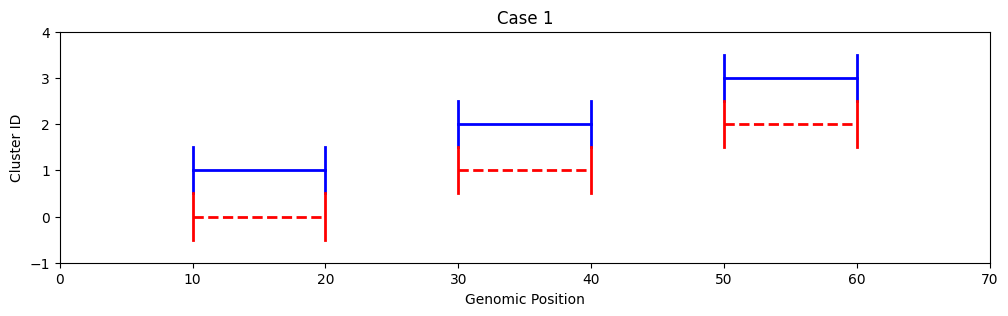

In [35]:

case_1 = [
	pr.from_dict({"Chromosome": ["chr1"], "Start": [10], "End": [20]}),
	pr.from_dict({"Chromosome": ["chr1"], "Start": [30], "End": [40]}),
	pr.from_dict({"Chromosome": ["chr1"], "Start": [50], "End": [60]})]

concatenated = pr.concat(case_1)
clustered = concatenated.cluster()

plot_pyranges(clustered, 'Case 1')


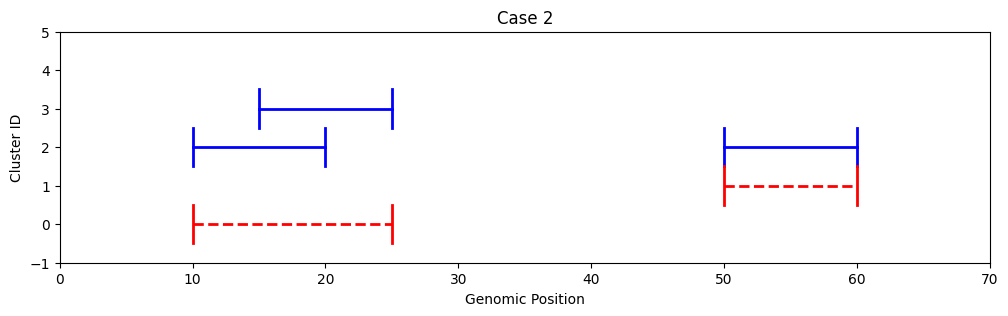

In [36]:

case_2 = [
	pr.from_dict({"Chromosome": ["chr1"], "Start": [10], "End": [20]}),
	pr.from_dict({"Chromosome": ["chr1"], "Start": [15], "End": [25]}),
	pr.from_dict({"Chromosome": ["chr1"], "Start": [50], "End": [60]})]

concatenated = pr.concat(case_2)
clustered = concatenated.cluster()

plot_pyranges(clustered, 'Case 2')


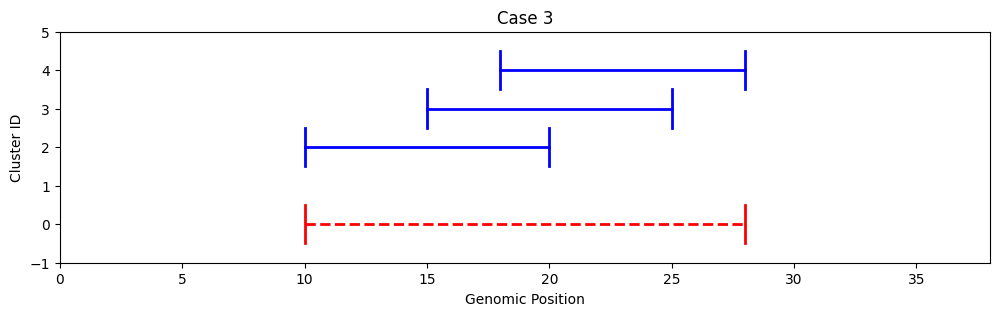

In [37]:

case_3 = [
	pr.from_dict({"Chromosome": ["chr1"], "Start": [10], "End": [20]}),
	pr.from_dict({"Chromosome": ["chr1"], "Start": [15], "End": [25]}),
	pr.from_dict({"Chromosome": ["chr1"], "Start": [18], "End": [28]})]

concatenated = pr.concat(case_3)
clustered = concatenated.cluster()

plot_pyranges(clustered, 'Case 3')



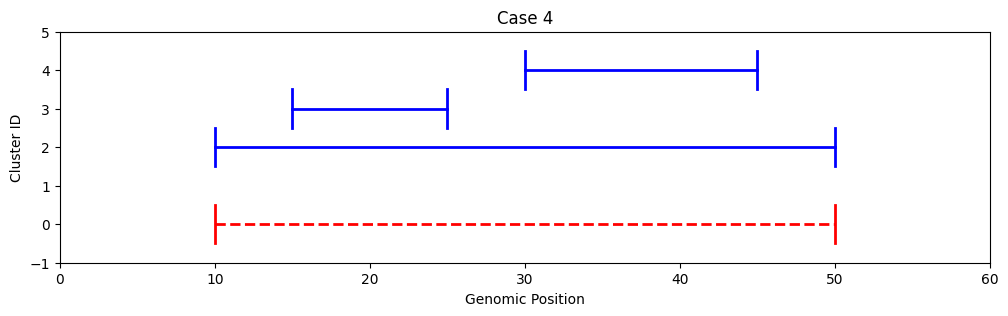

In [38]:
case_4 = [
	pr.from_dict({"Chromosome": ["chr1"], "Start": [10], "End": [50]}),
	pr.from_dict({"Chromosome": ["chr1"], "Start": [15], "End": [25]}),
	pr.from_dict({"Chromosome": ["chr1"], "Start": [30], "End": [45]})]

concatenated = pr.concat(case_4)
clustered = concatenated.cluster()

plot_pyranges(clustered, 'Case 4')

In [46]:
list(c1.Chromosome)[0]

'chr1'

In [48]:
compare_utils.vector_crosser(['tx_1','tx_2','tx_3'],['tx_1','tx_2','tx_3'])

{'V1': ['tx_2', 'tx_2', 'tx_1'], 'V2': ['tx_1', 'tx_3', 'tx_3']}